<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Install-dependencies" data-toc-modified-id="Install-dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Install dependencies</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-generated-qa-pairs" data-toc-modified-id="Load-generated-qa-pairs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load generated qa pairs</a></span></li><li><span><a href="#Load-Word2Vec" data-toc-modified-id="Load-Word2Vec-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Word2Vec</a></span></li><li><span><a href="#Construct-graphs" data-toc-modified-id="Construct-graphs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Construct graphs</a></span></li></ul></div>

# Install dependencies

In [1]:
#!pip install gensim

# Imports

In [2]:
import json
import gensim.downloader as api

#--- libs imported by kk
import sys
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import pdb
import numpy as np
import matplotlib
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams['text.usetex'] = True
import warnings
warnings.filterwarnings('ignore')


# utility functions

In [3]:
#--- aux functions

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True,**kwargs):
    '''
    return pdf
    '''
    if 'bins' in kwargs:
        bins = kwargs['bins'] 
    elif not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        assert not 'bins' in kwargs and linscale
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)

    bins = kwargs['bins'] if 'bins' in kwargs else bins
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    if density:
    	nth=1   
    	hist = hist[count>nth]
    	edges = edges[:-1][count>nth]
    	count = count[count>nth]
    else:
        count=1

    return  hist, edges, hist / count**0.5


def PltErr( xdata, ydata, 
            yerr = None,
            xstr = '',
            ystr = '',
            Plot = True,
            **kwargs
            ):
    '''
    plot data
    '''
    fontsize=kwargs['fontsize'] if 'fontsize' in kwargs else 20
    if not 'ax' in kwargs:
        fig = plt.figure( figsize = (4,4) if 'figsize' not in kwargs else kwargs['figsize'] )
        ax = fig.add_subplot(111)
#        ax.count = 0
        ax.markerss=['o','s','D','^','<','>','v']

#        ax.set_prop_cycle(marker=['o', '+', 'x', '*', '.', 'X'])
    else:
        ax = kwargs['ax']
#        ax.count += 1

        if 'twinx' in kwargs and kwargs['twinx']:
                ax = kwargs['ax'].twinx()
    #--- setting   
    ax.set_xlabel(xstr,fontsize=fontsize)
    ax.set_ylabel(ystr,fontsize=fontsize)
    ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
    #
    xerr = kwargs['xerr'] if 'xerr' in kwargs else None 
#
    if 'attrs' in kwargs:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])
        if 'fill_between' in kwargs and kwargs['fill_between']:
            ax.fill_between(xdata, ydata-yerr, ydata+yerr)
    else:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr,
                    fmt=kwargs['fmt'] if 'fmt' in kwargs else '-o',
                    label=kwargs['label'] if 'label' in kwargs else '',
                    markevery=kwargs['markevery'] if 'markevery' in kwargs else 1,
                    markersize=kwargs['markersize'] if 'markersize' in kwargs else 10,
                    marker=kwargs['marker'] if 'marker' in kwargs else 'o', #ax.markerss[(ax.count)%7],
                   )

    #--- plot
    #
#    ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
    #
    if 'ylim' in kwargs:
        ylim = kwargs['ylim'] 
        ax.set_ylim(ylim)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim'] 
        ax.set_xlim(xlim)
    #
    if 'xscale' in kwargs: 
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs: 
        ax.set_yscale(kwargs['yscale'])
    #
    if 'xticks' in kwargs:
        ax.set_xticks(list(map(float,kwargs['xticks'][1])))
#        ax.set_xticklabels(list(map(lambda x:'$%s$'%x,kwargs['xticks'][0])))
        ax.set_xticklabels(kwargs['xticks'][0])
    #
    if 'yticks' in kwargs:
        ax.set_yticks(list(map(float,kwargs['yticks'][1])))
        ax.set_yticklabels(list(map(lambda x:'$%s$'%x,kwargs['yticks'][0])))
        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    ndecade_x = kwargs['ndecade_x'] if 'ndecade_x' in kwargs else 1
    ndecade_y = kwargs['ndecade_y'] if 'ndecade_y' in kwargs else 1
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY,nevery_x=ndecade_x,nevery_y=ndecade_y)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs:
        plt.legend(**kwargs['legend'])
	#
    if 'halfopen' in kwargs and kwargs['halfopen']:
        ax.spines['right'].set_visible(False) #--- half open
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

    if 'title' in kwargs: #Plot:
        plt.savefig(kwargs['title'],dpi=300 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight', 
                    pad_inches=0.0)
    if Plot:
        plt.show()
    #
    
    
#    if not 'ax' in kwargs:
    return ax


class Symbols:
    '''
    plot settings for matplotlib
    '''
    
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,**kwargs):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5 if not 'capsize' in kwargs else kwargs['capsize'],
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    '''
    legend settings for matplolib
    '''
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

def PutMinorTicks(ax, LOGY=None,LOGX=None, nevery_x=1,nevery_y=1):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(10**np.arange(ymin,ymax+nevery_y,nevery_y))
#        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(10**np.arange(ymin,ymax+nevery_x,nevery_x))
#        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
#        print(10**np.arange(ymin,ymax,nevery_x))
#        ax.set_xticks(np.logspace(ymin,ymax,int(nbin/nevery_x)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


# Load generated qa pairs

In [4]:
path = '../data'
with open("%s/generated_dataset_qa_from_sentences_n=2.json"%path, "r") as f:
    qa_dataset = json.load(f)
qa_dataset[:2]

[{'This observed orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis, as seen in Fig. 6(b). The crystallographic phases, twinning, and orientation relationship will be discussed subsequently in more detail. 4 Discussion 4.1 Solidification and particle microstructure The microstructures of the rapidly solidified UNb particles display a clear dependence on particle size, as seen in Fig. 1.': [{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?',
    'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'},
   {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?',
    'Answer': 

To get only qa pairs do this:

In [5]:
qa_dataset[0].values()

dict_values([[{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?', 'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'}, {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?', 'Answer': ' Yes, the microstructures of the rapidly solidified UNb particles display a clear dependence on particle size.'}, {'Question': ' Will the crystallographic phases, twinning, and orientation relationship be discussed in more detail?', 'Answer': ' Yes, the crystallographic phases, twinning, and orientation relationship will be discussed subsequently in more detail.'}]])

In [6]:
all_qa_pairs = []
for data in qa_dataset:
    all_qa_pairs.extend(*data.values())

In [7]:
data.values()

dict_values([[{'Question': ' What was the sample cut for?', 'Answer': ' The sample was cut to observe the horizontal cross section.'}, {'Question': ' What was used to polish the sample?', 'Answer': ' Diamond paste was used to polish the sample.'}, {'Question': ' What was used to perform the B element analysis?', 'Answer': ' An electron probe micro analyzer-wavelength dispersive X-ray spectroscopy (EPMA-WDS) was used to perform the B element analysis.'}]])

Each qa pair is a dictionary with keys adequately named "Question" and "Answer"

In [8]:
all_qa_pairs[0:2]

[{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?',
  'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'},
 {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?',
  'Answer': ' Yes, the microstructures of the rapidly solidified UNb particles display a clear dependence on particle size.'}]

In [9]:
example_qa = all_qa_pairs[0]

print(f"Question: {example_qa['Question']}")
print(f"Answer: {example_qa['Answer']}")

Question:  What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?
Answer:  The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.


# Load Word2Vec

In [5]:
wv = api.load('word2vec-google-news-300')

Word2Vec is a ML model that encodes words into verctors (in this case 300 numbers long).

In [12]:
vec_king = wv['king']

In [ ]:
vec_king.shape

In [ ]:
vec_king[:40]

You use this to find similar words

In [ ]:
wv.most_similar(positive=["queen"], topn=10)

Or find words with similar verctors you your word

In [ ]:
wv.most_similar(positive=[vec_king], topn=10)

You can even do some math on vectors and expect to have some correlation in how close those vectors get to vectors of known words

In [ ]:
vec_man = wv['man']
vec_woman = wv['woman']

In [ ]:
new_vec = vec_king - vec_man + vec_woman

Queen is more similar now then before.

In [ ]:
wv.most_similar(positive=[new_vec], topn=3)

Not all words are present in word2vec dictionary

In [ ]:
vec_cam = wv['cameroon']

However letter case matters here

In [ ]:
vec_cam = wv['Cameroon']

In this case you can either train new model with increased vocabulary or skip that word.

In [ ]:
for word in "Why is cameroon not in the vocabulary but Cameroon is ?".split():
    try:
        embedding = wv[word]
    except KeyError:
        print(f"No word {word} in vocabulary.")
        continue
    
    print(f"{word}: {embedding[:5]}.....")
    


And to get back to our data

In [ ]:
print(example_qa['Question'])
print()
example_question = example_qa['Question'].replace("?", " ?") # add space before "?" or we could remove it since it's not in the vocab anyway.

for word in example_question.split():
    try:
        embedding = wv[word]
    except KeyError:
        print(f"No word {word} in vocabulary.")
        continue
    
    print(f"{word}: {embedding[:5]}.....")
    


# Construct graphs

In [14]:
class GraphNetwork:
    '''
    Class for embedded-word graphs storing nodes with optional attributes
    
    Edges are represented as links between nodes with optional data.
    '''
    
    
    def __init__(self, wv, ndim, verbose=False, **kwargs):
        self.verbose = verbose
        self.wv = wv
        self.ndim = ndim
        self.sw_nltk = stopwords.words('english')

        list(map(lambda x:setattr(self,x,kwargs[x]),kwargs))
    
    
    def Embedding(self, word):
        '''
        word embedding using word2vec
        '''
        try:
            return self.wv[word]
        except KeyError:
            if self.verbose:
                print(f"No word {word} in vocabulary.")
            return np.array([np.nan]*self.ndim)
#             continue

    def ParseStringArrays(self, data):
        '''
        embedd array of strings in a vector space
        '''
        #--- positions in the embedded space
        self.position = np.concatenate(list(map(lambda x:self.ParseString(x),data)),axis=0)

        if self.verbose:
            print('position.shape:',self.position.shape)

        
        self.nnode = self.position.shape[0]
        
        
    def ParseString(self,strr):
        '''
        embedd string in a vector space

        '''
        #--- preprocess qa pair
        #--- self.data_preprocessed to be used to define corresponding edges
        self.data_preprocessed = list(map(lambda x:self.Preprocess(x),strr))
        if self.verbose:
            print('qa pair:',strr)
            print('preprocessed qa pair:',self.data_preprocessed)

        #--- data_preprocessed used here to define nodes
        #--- concat
        if self.answer_only:
            data_preprocessed = self.data_preprocessed[ 1 ]
        else:
            data_preprocessed = ' '.join(self.data_preprocessed)
        if self.verbose:
            print('concatenated qa:',data_preprocessed)

        #--- rm duplicates
        example_question_unique = list(set(GraphNetwork.Split(data_preprocessed)))
        data_preprocessed = ' '.join(example_question_unique)
        if self.verbose:
            print('unique qa:',data_preprocessed)
#        words_unique = list(set(words))


        #--- embedding in feature space
        position = np.c_[list(map(lambda x: self.Embedding(x),GraphNetwork.Split(data_preprocessed)))]
        assert position.shape[1] == self.ndim, 'dimension of %s != %s'(data_preprocessed,self.ndim)
        
        #--- rm nan's
        position, filtr = GraphNetwork.RemoveNans(position)
        
        
        #--- return center of mass
#        center = np.mean(position[filtr],axis=0)
    
        #--- add noise
        GraphNetwork.Addnoise(position)
#        words = np.c_[list(map(lambda x:self.ParseString(x)[1],data))]
        
        #--- process        



#         self.nnode = self.position.shape[0]
        self.labels = np.array(GraphNetwork.Split(data_preprocessed))[filtr]
    
        #--- rm words that don't exist in vocabulary
        for item, indx in zip(self.data_preprocessed,range(2)):
            words = [word for word in GraphNetwork.Split(item) if word in self.labels]
            self.data_preprocessed[indx] = " ".join(words)

    
        
        
        return position #[filtr] # , example_question[filtr] #[filtr], np.array(example_question_unique)[filtr]

    def Preprocess(self,text):
        #--- replace
#        data_replaced_qmark = list(map(lambda x:GraphNetwork.Replace(x),data))
        text_replaced_qmark = GraphNetwork.Replace(text)
        #--- concat
#        data_concat = np.concatenate(list(map(lambda x:x.split(),data_replaced_qmark)))
        
        #--- rm duplicates
#        data_unique = list(set(data_concat))

        #--- rm stop words
        words = [word for word in GraphNetwork.Split(text_replaced_qmark) if word.lower() not in self.sw_nltk]
        new_text = " ".join(words)

        
        return new_text
    
    def BuildGraph(self,thresh=1e-1):
        '''
        construct a geometric graph
        '''
        dim=self.ndim
#         w = {i: 0.5 for i in range( self.nnode ) }
#         self.graph = nx.geographical_threshold_graph(self.nnode, 1.0/thresh,dim=dim,
#                                                      pos=self.position, weight=w)
        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(range( self.nnode ))

        
        #--- relabel graph
        nodes = self.graph.nodes
        mapping = dict(zip(nodes,self.labels))
        self.graph = nx.relabel_nodes(self.graph, mapping)
        
        #--- add edges
        assert len(self.graph.edges) == 0, 'decrease threshold!'
        if self.answer_only:
            self.data_preprocessed = [self.data_preprocessed[1]]
        list(map(lambda x:self.AddEdge(GraphNetwork.Split(x)),self.data_preprocessed))
        
        #--- rm dangling nodes
        rm_nodes = list(map(lambda x:x[0] if x[1]==0 else None,nx.degree(self.graph)))
        self.graph.remove_nodes_from(rm_nodes)

    def AddEdge(self,question):
        #--- edge tuples: include 1st and 2nd neighbors
        edge_tuples=list(zip(question,question[1:])) + list(zip(question,question[2:]))
        self.graph.add_edges_from(edge_tuples)  # using a list of edge tuples
        #--- remove newly-added nodes
        nodes = np.array(list(self.graph.nodes.keys()))
        
        degrees = list(map(lambda x: self.graph.degree(x), nodes))         
        filtr = np.array(degrees) == 0
        self.graph.remove_nodes_from(nodes[filtr])
        
    def PlotGraph(self):
        '''
        plot grpahs
        '''
        
#         edge_list = np.array(self.graph.edges())
#         inv_distance = np.log10(np.array(list(map(lambda x:1/self.distance_matrix[x[0],x[1]],edge_list))))
#         xmin = np.min(inv_distance)
#         xmax = np.max(inv_distance)
#         inv_distance -= xmin
#         inv_distance /= (xmax-xmin)
        
        #--- only connected nodes
#        nodelist = list(set(edge_list.flatten()))
        
        #--- plot
        subax1 = plt.subplot(111)
        nx.draw_networkx(self.graph, #pos=dict(zip(self.graph.nodes,self.position[:,0:2])),
#                   labels=dict(zip(range(self.nnode),self.labels)),
                with_labels=True, 
                 font_weight='bold',
#                          nodelist=nodelist,
                         node_color='yellow',
                         linewidths=0.5,
                         font_size=8.0,
#                          width = inv_distance, #(inv_distance-xmin)/(xmax-xmin),
#                          edge_vmin=0,edge_vmax=1, 
#               font_size=8,
#                node_size=30,
               )
        
        #--- plot edge labels
#         edge_tuples = list(map(lambda x:(x[0],x[1]),edge_list))
#         inv_distance_str = list(map(lambda x:'%3.2f'%x,inv_distance))
#         edge_labels = dict(zip(edge_tuples,inv_distance_str))
#         nx.draw_networkx_edge_labels(self.graph,pos=dict(zip(self.graph.nodes,self.position[:,0:2])),
# #                                     edge_labels=edge_labels,
#                                     font_color='red',
#                                      font_size=6,
#                                     )
        plt.savefig('png/graph.png',dpi=300)

    def DistanceMatrix(self):
        '''
        compute distance matrix
        '''
        self.distance_matrix = np.c_[list(map(lambda y:\
                              list(map(lambda x: GraphNetwork.Distance(x,self.position[y]) ,self.position)), range(self.nnode)))]
        
    def PlotPairDistance(self,rcut=1.0):
        '''
        distance distribution
        '''
        rij = np.concatenate(list(map(lambda x:self.distance_matrix[x,x+1:],range(self.nnode))))
        hist, bin_edges, err = GetPDF(rij[rij>=rcut], n_per_decade=32)

        !mkdir png
        PltErr(bin_edges,hist,
                  yerr=err,
                   xscale='log',yscale='log',
                   xstr='distance',ystr='probability',
                   title='png/pairwise_distance_distribution.png',
                   xlim=(1e-1,100),
                  )
        
    def PlotDegree(self):
        '''
        degree distribution
        '''
        degrees = np.array([self.graph.degree(n) for n in self.graph.nodes()])
        filtr = degrees > 0
        hist, bin_edges, err = GetPDF(degrees[filtr], n_per_decade=16)

#         np.savetxt('png/degree2.txt',np.c_[hist, bin_edges, err])
        PltErr(bin_edges,hist,
                  yerr=err,
                   xscale='log',yscale='log',
                    xstr='degree',ystr='probability',
                   title='png/degree_distribution.png',
                  )



    def TopoImportance( self, **kwargs ):
        if 'degree_centrality' in kwargs:
            self.centrality = GraphNetwork.SortDictionary(nx.degree_centrality(self.graph))
        if 'closeness_centrality' in kwargs:
            self.centrality = GraphNetwork.SortDictionary(nx.closeness_centrality(self.graph))
        if 'betweenness_centrality' in kwargs:
            self.centrality = GraphNetwork.SortDictionary(nx.betweenness_centrality(self.graph))
        if 'percolation_centrality' in kwargs:
            nx.set_node_attributes(self.graph, 0.1, 'percolation')
            self.centrality = GraphNetwork.SortDictionary(nx.percolation_centrality(self.graph))
        
        
        nodei = self.centrality[ 0 ][ 1 ]
        nodej = self.centrality[ 1 ][ 1 ]
        return '%s %s'%(nodei,nodej),self.Distance(self.Embedding(nodej),self.Embedding(nodei))
    
    def PlotCentrality( self, qa_tuple, **kwargs ):
        slist = self.centrality
        r = list(map(lambda x:x[0],slist))

        xvals = np.c_[np.array(slist)][:,1]
        yvals = np.c_[np.array(slist)[:,0]].astype(float)
        df = pd.DataFrame(yvals,
                          index=xvals,
                          columns=['degree centrality'])
        ax = df.plot.bar(rot=90)#,xticks=xvals) #,use_index=xvals)
        
        #--- make the key word bold
        word = slist[0][1]
        sarr = np.array(GraphNetwork.Split(qa_tuple[1]))
        indx = np.arange(len(sarr))[sarr == word][0]
        str1 = ' '.join(sarr[:indx]) 
        str2 = ' %s '%sarr[ indx ] 
        str3 = ' '.join(sarr[ indx+1:])
        answer_str = '\nanswer= '+str1+r' $\bf{\underline{%s}}$ '%str2+str3
        #--- question
        sarr = np.array(GraphNetwork.Split(qa_tuple[0]))
        if word in sarr:
            indx = np.arange(len(sarr))[sarr == word][0]
            strr1 = ' '.join(sarr[:indx]) 
            strr2 = ' %s '%sarr[ indx ] 
            strr3 = ' '.join(sarr[ indx+1:])
            question_str = 'question= '+strr1+r' $\bf{\underline{%s}}$ '%strr2+strr3
        else:
            question_str = 'question= '+qa_tuple[0]
        ax.set_title(question_str+answer_str, 
                    {
#             'color': 'black',
            'fontsize':10,
            'verticalalignment': 'baseline'},
                    )
        #
        nevery = 1
        ax.set_xticks(range(0,len(xvals),nevery))
        ax.set_xticklabels(xvals[::nevery])
        plt.savefig(kwargs['title'],bbox_inches='tight',pad_inches=0)
        plt.show()


    @staticmethod
    def SortDictionary(sdict,reverse=True):
        slist = list(map(lambda x: (sdict[x],x),sdict))
        slist.sort(reverse=reverse)
        return slist
    
    @staticmethod
    def Distance(xi,xj):
        return np.sum((xi-xj)**2)

    @staticmethod
    def withinThreshold(G, thresh):
        for item in G.edges():
            xi = pos[item[0]]
            xj = pos[item[1]]
            dist = GraphNetwork.Distance(xi,xj)
            assert dist <= thresh, '%s <= %s!'%(dist,thresh)
            
    @staticmethod
    def Replace(strr):
        strr = strr.replace("?", " ?")
        strr = strr.replace(".", " .")
        strr = strr.replace(",", " ,")
        return strr
        

    
    @staticmethod
    def RemoveNans(array):
        filtr = ~np.any(np.isnan(array),axis=1)
        return array[filtr], filtr

    @staticmethod
    def Addnoise(position):
        noise = np.random.normal(size=position.size,
                scale=1e-6).reshape(position.shape)
        position += noise

    @staticmethod
    def Split(strr):
        #--- the following strings should not be split
        #--- add entries per question as necessary 
        tokenizer = MWETokenizer([('[','10','1','¯',']'),
                                  ('[','1','¯','32',']'),
                                  ('(', 'α+β', ')', '-Zr'),
                                  ('Fig', '.', '5'),
                                 ])
        return tokenizer.tokenize(word_tokenize(strr))


## main()

 The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.
split:['The', 'orientation', 'relationship', 'results', 'in', 'the', 'dendrite', 'core', 'being', 'slightly', 'off', 'of', 'the', '[_10_1_¯_]', 'zone', 'axis', 'when', 'the', 'interdendritic', 'region', 'is', 'tilted', 'to', 'the', '[_1_¯_32_]', 'zone', 'axis', '.']

mkdir: png: File exists


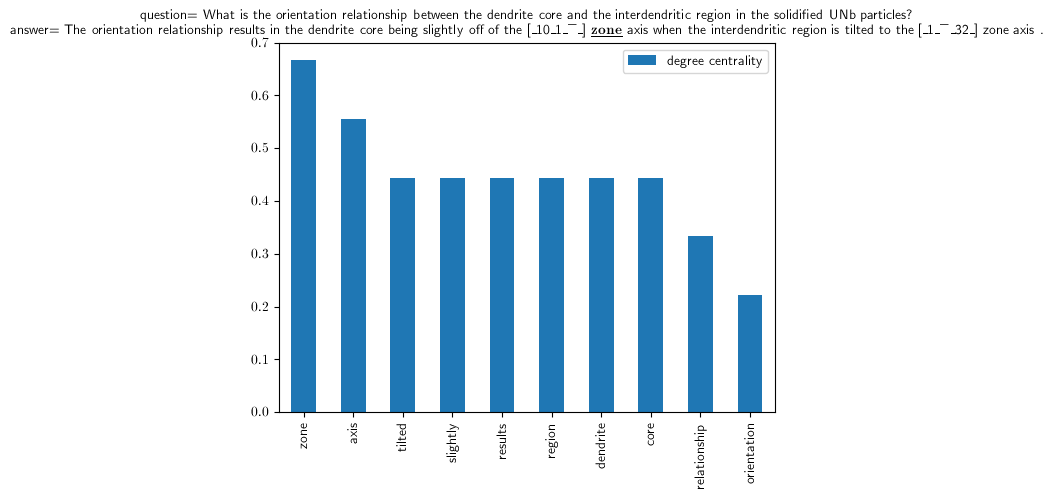

 Yes, the microstructures of the rapidly solidified UNb particles display a clear dependence on particle size.
split:['Yes', ',', 'the', 'microstructures', 'of', 'the', 'rapidly', 'solidified', 'UNb', 'particles', 'display', 'a', 'clear', 'dependence', 'on', 'particle', 'size', '.']

mkdir: png: File exists


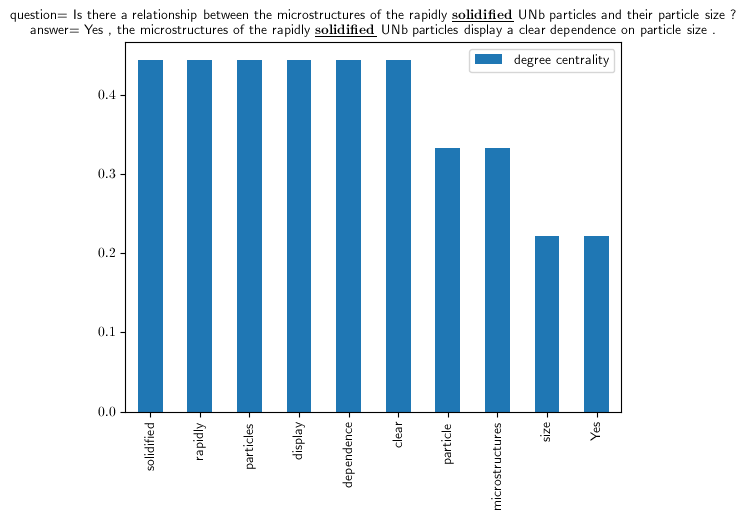

 Yes, the crystallographic phases, twinning, and orientation relationship will be discussed subsequently in more detail.
split:['Yes', ',', 'the', 'crystallographic', 'phases', ',', 'twinning', ',', 'and', 'orientation', 'relationship', 'will', 'be', 'discussed', 'subsequently', 'in', 'more', 'detail', '.']

mkdir: png: File exists


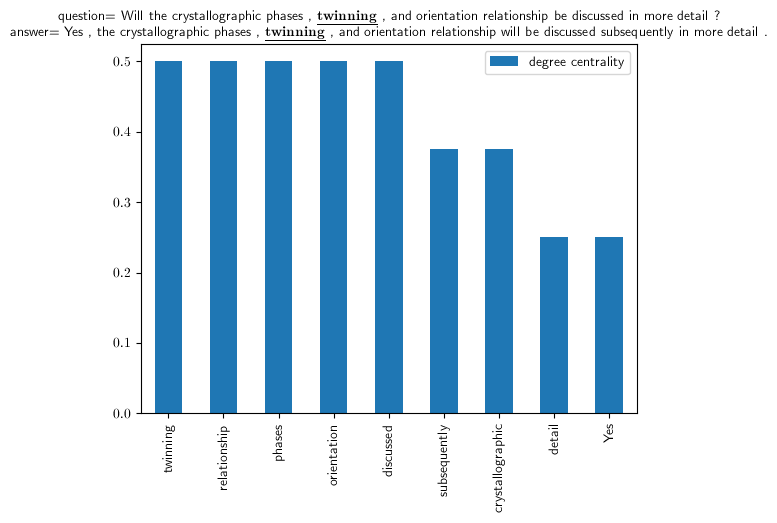

 The phase transformation temperature of Zr-1Nb-1Sn-0.1Fe alloy cladding from (α+β)-Zr to β-Zr during steam oxidation is between 900 and 1000 °C.
split:['The', 'phase', 'transformation', 'temperature', 'of', 'Zr-1Nb-1Sn-0.1Fe', 'alloy', 'cladding', 'from', '(_α+β_)_-Zr', 'to', 'β-Zr', 'during', 'steam', 'oxidation', 'is', 'between', '900', 'and', '1000', '°C', '.']

mkdir: png: File exists
 The weight gain of the specimens after subsequent oxidation at 1000 °C for 5130 s is shown in Fig. 5.
split:['The', 'weight', 'gain', 'of', 'the', 'specimens', 'after', 'subsequent', 'oxidation', 'at', '1000', '°C', 'for', '5130', 's', 'is', 'shown', 'in', 'Fig_._5', '.']

mkdir: png: File exists


RuntimeError: latex was not able to process the following string:
b'question= What is the phase transformation $\\\\bf{\\\\underline{ temperature }}$ of Zr-1Nb-1Sn-0.1Fe alloy cladding from (_\\u03b1+\\u03b2_)_-Zr to \\u03b2-Zr during steam oxidation ?'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpkym5lxd3 c834ae48eae58b60b4ee87293b57f604.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_2) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./c834ae48eae58b60b4ee87293b57f604.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))
(/opt/local/share/texmf-texlive/tex/latex/type1cm/type1cm.sty)
(/opt/local/share/texmf-texlive/tex/latex/cm-super/type1ec.sty
(/opt/local/share/texmf-texlive/tex/latex/base/t1cmr.fd))
(/opt/local/share/texmf-texlive/tex/latex/base/inputenc.sty)
(/opt/local/share/texmf-texlive/tex/latex/geometry/geometry.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/keyval.sty)
(/opt/local/share/texmf-texlive/tex/generic/iftex/ifvtex.sty
(/opt/local/share/texmf-texlive/tex/generic/iftex/iftex.sty)))
(/opt/local/share/texmf-texlive/tex/latex/underscore/underscore.sty)
(/opt/local/share/texmf-texlive/tex/latex/base/textcomp.sty)
(/opt/local/share/texmf-texlive/tex/latex/l3backend/l3backend-dvips.def)
No file c834ae48eae58b60b4ee87293b57f604.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character α (U+03B1)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 ... Zr-1Nb-1Sn-0.1Fe alloy cladding from (_α
                                                  +β_)_-Zr to β-Zr during ...
No pages of output.
Transcript written on tmpkym5lxd3/c834ae48eae58b60b4ee87293b57f604.log.




<Figure size 640x480 with 1 Axes>

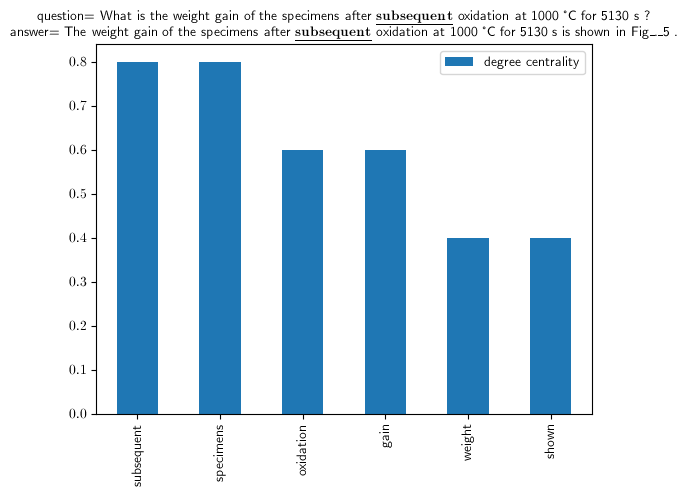

 No, the specimen pre-oxidized at 900 °C does not show prior-β phase structure formed during cooling as β-Zr transformed to α-Zr.
split:['No', ',', 'the', 'specimen', 'pre-oxidized', 'at', '900', '°C', 'does', 'not', 'show', 'prior-β', 'phase', 'structure', 'formed', 'during', 'cooling', 'as', 'β-Zr', 'transformed', 'to', 'α-Zr', '.']

mkdir: png: File exists
 ML provides a universal tool for modeling interatomic interactions for HEMs.
split:['ML', 'provides', 'a', 'universal', 'tool', 'for', 'modeling', 'interatomic', 'interactions', 'for', 'HEMs', '.']

mkdir: png: File exists


RuntimeError: latex was not able to process the following string:
b'question= Does the specimen pre-oxidized at 900 \\xb0C show prior-\\u03b2 phase $\\\\bf{\\\\underline{ structure }}$ formed during cooling ?'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpzgmuuxl8 03a0c3f8ff1c90c4ddfc26ebd6dc46b2.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021/MacPorts 2021.58693_2) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./03a0c3f8ff1c90c4ddfc26ebd6dc46b2.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))
(/opt/local/share/texmf-texlive/tex/latex/type1cm/type1cm.sty)
(/opt/local/share/texmf-texlive/tex/latex/cm-super/type1ec.sty
(/opt/local/share/texmf-texlive/tex/latex/base/t1cmr.fd))
(/opt/local/share/texmf-texlive/tex/latex/base/inputenc.sty)
(/opt/local/share/texmf-texlive/tex/latex/geometry/geometry.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/keyval.sty)
(/opt/local/share/texmf-texlive/tex/generic/iftex/ifvtex.sty
(/opt/local/share/texmf-texlive/tex/generic/iftex/iftex.sty)))
(/opt/local/share/texmf-texlive/tex/latex/underscore/underscore.sty)
(/opt/local/share/texmf-texlive/tex/latex/base/textcomp.sty)
(/opt/local/share/texmf-texlive/tex/latex/l3backend/l3backend-dvips.def)
No file 03a0c3f8ff1c90c4ddfc26ebd6dc46b2.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/opt/local/share/texmf-texlive/tex/latex/base/ts1cmss.fd)

! Package inputenc Error: Unicode character β (U+03B2)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 ...imen pre-oxidized at 900 °C show prior-β
                                                   phase $\bf{\underline{ st...
No pages of output.
Transcript written on tmpzgmuuxl8/03a0c3f8ff1c90c4ddfc26ebd6dc46b2.log.




<Figure size 640x480 with 1 Axes>

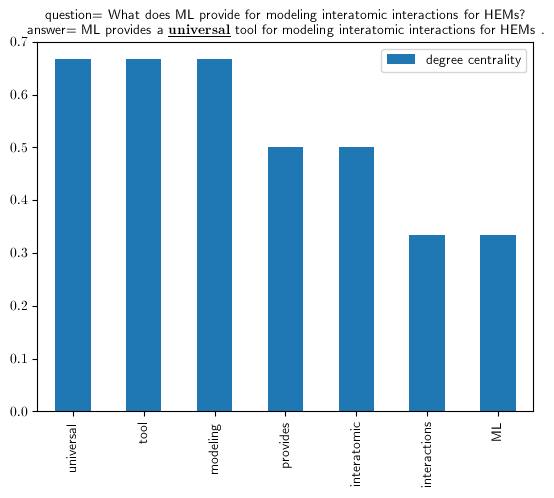

 Empirical formula may be insufficient to describe the complex interactions due to chemical complexity.
split:['Empirical', 'formula', 'may', 'be', 'insufficient', 'to', 'describe', 'the', 'complex', 'interactions', 'due', 'to', 'chemical', 'complexity', '.']

mkdir: png: File exists


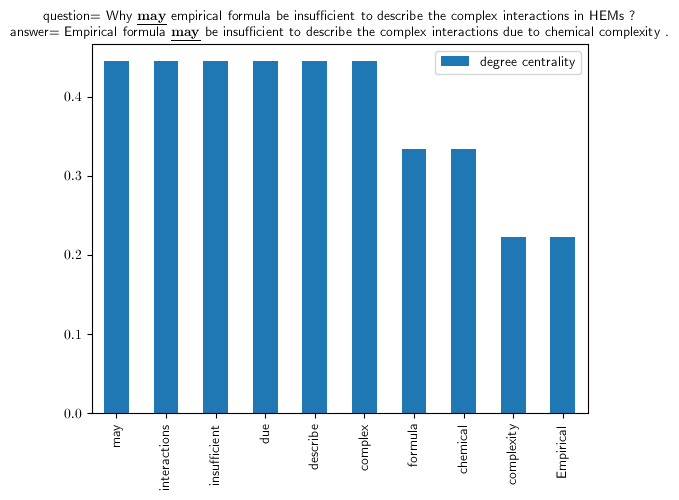

 There is a need to refine ML models for HEMs since there are a wide variety of ML algorithms with different mathematical formalisms.
split:['There', 'is', 'a', 'need', 'to', 'refine', 'ML', 'models', 'for', 'HEMs', 'since', 'there', 'are', 'a', 'wide', 'variety', 'of', 'ML', 'algorithms', 'with', 'different', 'mathematical', 'formalisms', '.']

mkdir: png: File exists


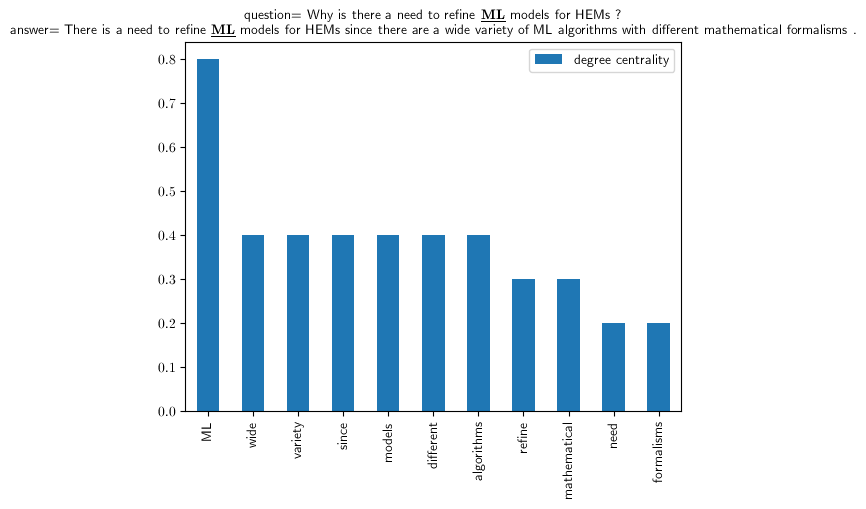

 Cesium uranates cause fuel pin swelling.
split:['Cesium', 'uranates', 'cause', 'fuel', 'pin', 'swelling', '.']

mkdir: png: File exists


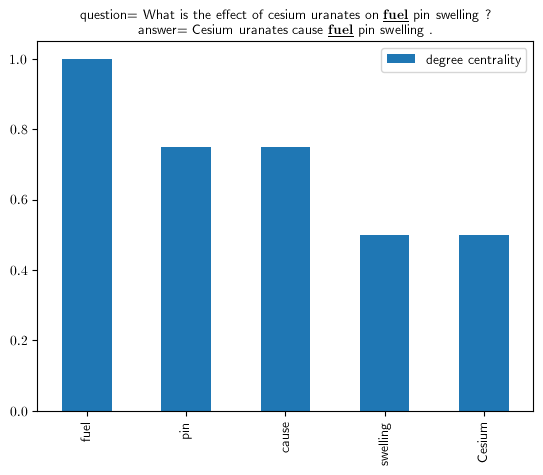

 Cesium is suspected to form the chemical bonding between fuel and clad.
split:['Cesium', 'is', 'suspected', 'to', 'form', 'the', 'chemical', 'bonding', 'between', 'fuel', 'and', 'clad', '.']

mkdir: png: File exists


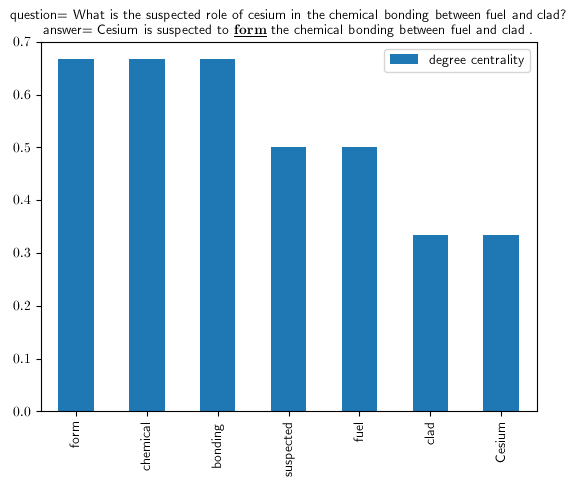

 The product of the reaction between iodine and cesium is cesium iodide CsI.
split:['The', 'product', 'of', 'the', 'reaction', 'between', 'iodine', 'and', 'cesium', 'is', 'cesium', 'iodide', 'CsI', '.']

mkdir: png: File exists


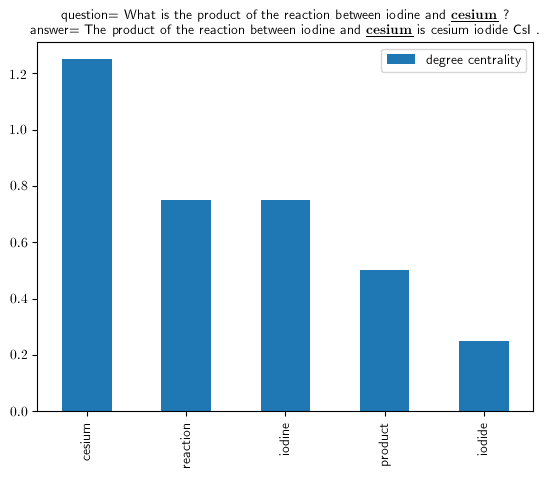

 The release rate model solves the diffusion equation in an infinite cylinder geometry.
split:['The', 'release', 'rate', 'model', 'solves', 'the', 'diffusion', 'equation', 'in', 'an', 'infinite', 'cylinder', 'geometry', '.']

mkdir: png: File exists


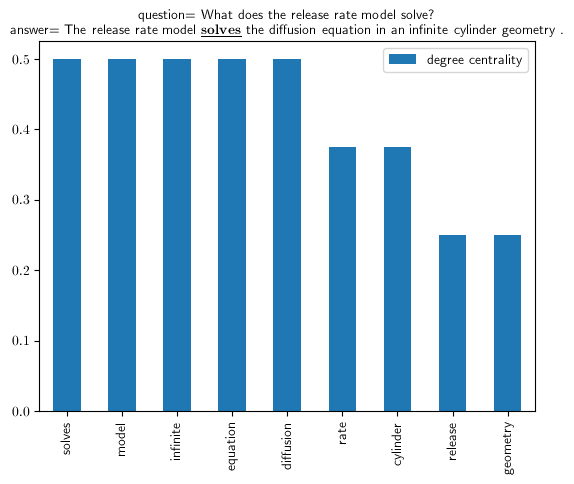

 The effective transport parameters evaluated for each experimental temperature are D eff and K s,eff.
split:['The', 'effective', 'transport', 'parameters', 'evaluated', 'for', 'each', 'experimental', 'temperature', 'are', 'D', 'eff', 'and', 'K', 's', ',', 'eff', '.']

mkdir: png: File exists


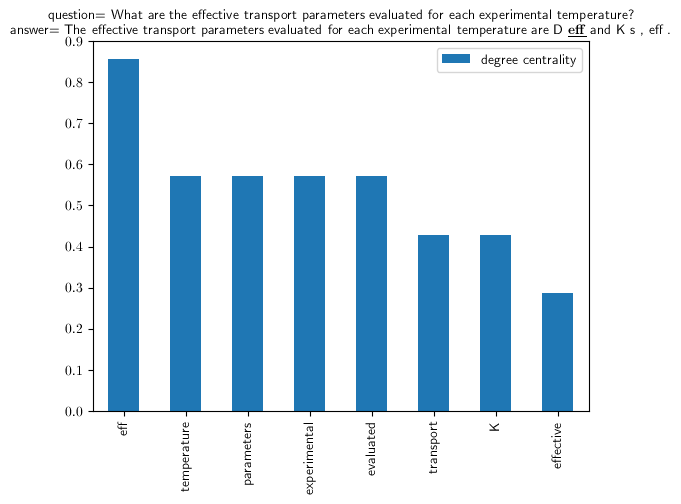

 The theoretical expression for the measured pressure is obtained from the non-stationary solution of radial Fick's second law in the three phases.
split:['The', 'theoretical', 'expression', 'for', 'the', 'measured', 'pressure', 'is', 'obtained', 'from', 'the', 'non-stationary', 'solution', 'of', 'radial', 'Fick', "'s", 'second', 'law', 'in', 'the', 'three', 'phases', '.']

mkdir: png: File exists


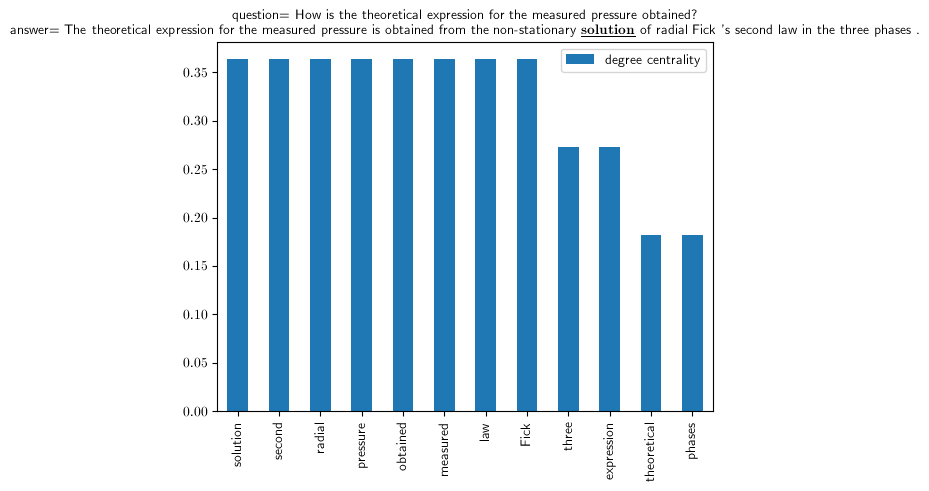

In [16]:
def main():
    
    #--- create qa pairs
    all_qa_pairs = []
    for data in qa_dataset:
        all_qa_pairs.extend(*data.values())

    #--- dictionary of q&a's
    qa_dict = {}
    for item in all_qa_pairs:
        if not 'Question' in item:
            continue
        qa_dict.setdefault(item['Question'],[]).append(item['Answer'])
        
    qa_tuples = list(map(lambda x: (x,qa_dict[x][0]), qa_dict.keys()))
    
    #--- setup your graph
    gn = GraphNetwork(wv,
                      300, #--- dimension of the vector space
#                            verbose=True,
                      answer_only = True,
                     )
    
    #--- loop through the qa pairs
    dict_nodes_dist = {}
    for qa_tuple, count in zip(qa_tuples[:15],range(sys.maxsize)):
        
#         print(qa_tuple[1])
#         print('split:%s\n'%GraphNetwork.Split(qa_tuple[1]))
        
        gn.ParseStringArrays( 
       [qa_tuple],
#          [(' What flavour ice cream do you prefer?','I like chocolate ice cream.')],
        )
        
        gn.BuildGraph(thresh=1e-10)
        
#         gn.PlotDegree()

        key, dist = gn.TopoImportance(
                          degree_centrality = True,
#                         closeness_centrality=True,
#                         betweenness_centrality=True,
#                         percolation_centrality=True,
        )
    
        dict_nodes_dist.setdefault(key,dist) 
        
        !mkdir png
#         gn.PlotGraph()

        try:
            gn.PlotCentrality(qa_tuple,
                             title='png/centrality_graph%s.png'%count
                             )
        except:
            continue
        
    return gn, dict_nodes_dist
gn, dict_nodes_dist = main()

## Plot Data

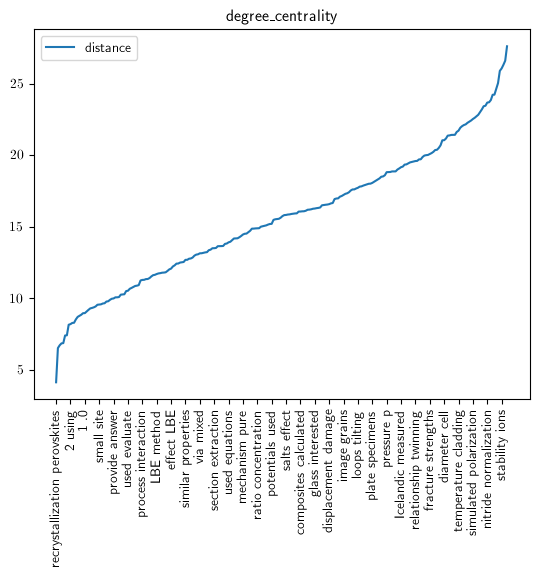

In [168]:
# # help(GraphNetwork)
# slist = GraphNetwork.SortDictionary(dict_nodes_dist,reverse=False)
# r = list(map(lambda x:x[0],slist))

# xvals = np.c_[np.array(slist)][:,1]
# yvals = np.c_[np.array(slist)[:,0]].astype(float)
# df = pd.DataFrame(yvals,
#                   index=xvals,
#                   columns=['distance'])
# ax = df.plot(rot=90)#,xticks=xvals) #,use_index=xvals)
# nevery = 8
# ax.set_title('degree_centrality')
# ax.set_xticks(range(0,len(xvals),nevery))
# ax.set_xticklabels(xvals[::nevery])
# plt.savefig('png/degree_centrality',bbox_inches='tight',pad_inches=0)
# plt.show()

In [ ]:
# G=gn.graph

# #A=nx.adjacency_matrix(gn.graph)
# #A.todense()
# #--- eigen values
# #nx.adjacency_spectrum(gn.graph)

# #---
# print('algebraic_connectivity=%s'%nx.algebraic_connectivity(gn.graph))

# # help(nx.algorithms)

# #---
# # nx.all_neighbors(gn.graph, 'relationship')

# # #list(nx.all_node_cuts(gn.graph))
# #nx.node_connectivity(G)

# #length = dict(nx.all_pairs_dijkstra_path_length(G))
# #length

# #nx.all_pairs_node_connectivity(G)

# #path = dict(nx.all_pairs_shortest_path_length(G))
# #path

# print('average_clustering=%s'%nx.average_clustering(G))

# #nx.average_degree_connectivity(G)

# #nx.average_neighbor_degree(G)

# print('average_node_connectivity=%s'%nx.average_node_connectivity(G))

# print('average_shortest_path_length=%s'%nx.average_shortest_path_length(G))

# print('center=%s'%nx.center(G))


# # #help(nx.connectivity)

# #nx.degree(G)

# # nx.degree_assortativity_coefficient(G)

# #nx.is_tree(G)

# print('number_of_edges=%s'%nx.number_of_edges(G)) #--- length

# print('number_of_nodes=%s'%nx.number_of_nodes(G))

# # print('eccentricity=%s'%nx.eccentricity(G))

# print('diameter=%s'%nx.diameter(G)) #--- Diameter of graph

# print('radius=%s'%nx.radius(G)) #--- radius of graph

In [ ]:
# data0=np.loadtxt('png/degree0.txt')
# data1=np.loadtxt('png/degree1.txt')
# data2=np.loadtxt('png/degree2.txt')

# symbols = Symbols()
# legends = Legends()
# legends.Set()

# ax = PltErr(None,None,Plot=False)

# hist, bin_edges, err = data0.T
# PltErr(bin_edges,hist,
#           yerr=err,
#            attrs=symbols.GetAttrs(count=0, label=r'$0.6$'),
#            ax=ax,
#            Plot=False,
#           )

# hist, bin_edges, err = data1.T
# PltErr(bin_edges,hist,
#           yerr=err,
#            attrs=symbols.GetAttrs(count=1,label=r'$0.8$'),
#            ax=ax,
#            Plot=False,
#           )

# hist, bin_edges, err = data2.T
# PltErr(bin_edges,hist,
#           yerr=err,
#            attrs=symbols.GetAttrs(count=2,label=r'$1.0$'),
#            ax=ax,
#            Plot=False,
#           )

# PltErr(None,None,
#            xscale='log',yscale='log',
#             xstr='degree',ystr='probability',
#            title='png/degree_distribution.png',
#             ax=ax,
#            legend=legends.Get()
#           )